<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <!-- <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1725947133/Frame_10507_1.png" alt="Logo" width="40%"> -->
  </a>
</div>


### 🖹 Descripción: 
<!-- Este notebook tiene como objetivo principal aplicar diversas técnicas de clasificación de datos en el conjunto de datos provienente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, y su finalidad es predecir de manera diagnóstica si un paciente tiene diabetes, basándose en un conjunto de mediciones realizadas. Enlace: [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). Con el fin de de explorar herramientas avanzadas de Machine Learning y contribuir al desarrollo del conocimiento a través de la investigación. -->

### ✍️ Autores: 
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha: 
9 de octubre de 2024

### 📝 Notas: 
<!-- Este notebook es el primero de dos que forman parte del primer proyecto del curso IC6200 - Inteligencia Artificial. Este notebook está titulado "diabetes", mientras que el siguiente se llama "alzheimer". -->

### Otras notas:
<!-- - Asegurarse de que Python esté instalado, junto con las bibliotecas necesarias: pandas, numpy, matplotlib, seaborn, scipy, ydata_profiling, utils. -->


# Configurción

## Importación de Librerías

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
import os

## Verificar PyThorch y CUDA

In [2]:
print("CUDA available:", torch.cuda.is_available())
if(torch.cuda.is_available()):
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())

CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: 0


## Definición de Constantes

In [3]:
SEED_VALUE = 153

BATCH_SIZE = 32

# EPOCHS = 5
EPOCHS = 20

TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'

IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5

LEARNING_RATE = 0.001
# LEARNING_RATE = 0.0005

DROPOUT_RATE = 0.5

## PyTorch settings

In [4]:
torch.manual_seed(SEED_VALUE)

## Filtros

In [5]:
def gausian_blur(img, order=21, sigma=21):
    np_img = np.array(img)
    filtered_img = cv2.GaussianBlur(np_img, (order,order), sigma)
    return Image.fromarray(filtered_img)

def bilateral_filter(img):
    """
    d: Diameter of each pixel neighborhood.
    
    sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
    
    sigmaSpace: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that
    their colors lie within the sigmaColor range.    
    """
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, 15, 75, 75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

## Creación de los dataframes

In [6]:
transform_r = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_b = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_c = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

# Train data
# Raw
train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_loader_r = DataLoader(dataset=train_dataset_r, batch_size=BATCH_SIZE, shuffle=True)
# Bilateral
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b)
train_loader_b = DataLoader(dataset=train_dataset_b, batch_size=BATCH_SIZE, shuffle=True)
# Canny
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c)
train_loader_c = DataLoader(dataset=train_dataset_c, batch_size=BATCH_SIZE, shuffle=True)

# Test data
# Raw
test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r)
test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=BATCH_SIZE, shuffle=True)
# Bilateral
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=BATCH_SIZE, shuffle=True)
# Canny
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=BATCH_SIZE, shuffle=True)


print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset_r)}')
print(f'Tamaño del conjunto de testing: {len(test_dataset_r)}')

Tamaño del conjunto de entrenamiento: 251
Tamaño del conjunto de testing: 66


## Efecto de los filtros

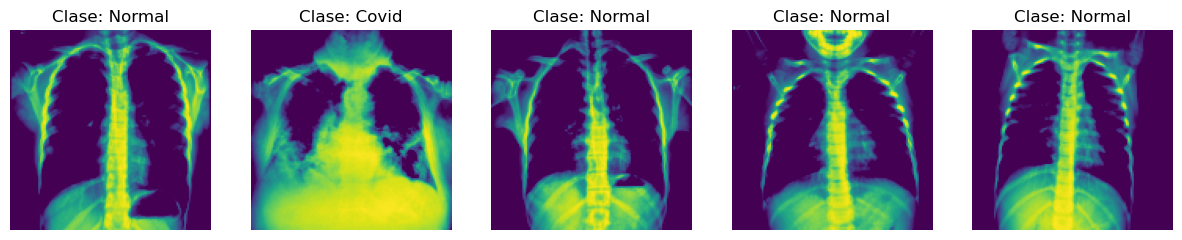

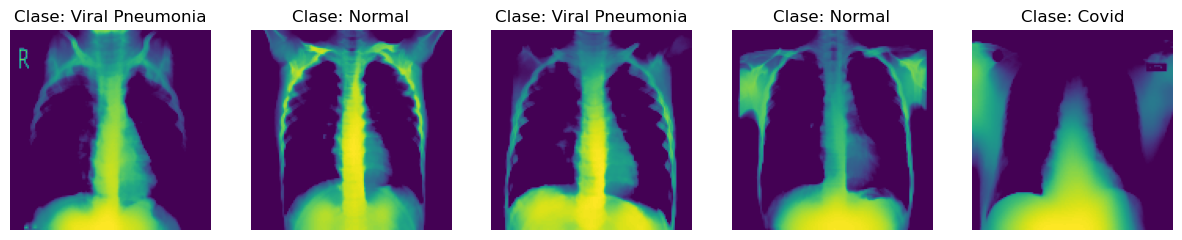

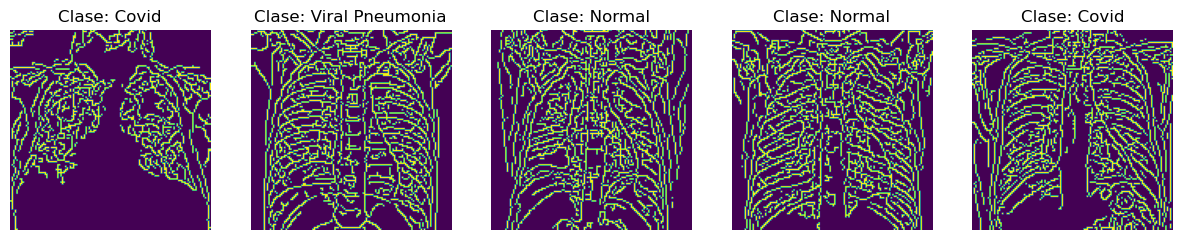

In [7]:
def show_first_five_images(data_loader, dataset):
    
    try:
        images, labels = next(iter(data_loader))
    
    except StopIteration:
        print("El DataLoader no tiene más datos.")
    
    except Exception as e:
        print(f"Ocurrió un error: {e}")
    
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    _, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax, img, label in zip(axes, images[:5], labels[:5]):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Clase: {dataset.classes[label.item()]}')
    plt.show()

show_first_five_images(train_loader_r, train_dataset_r)
show_first_five_images(train_loader_b, train_dataset_b)
show_first_five_images(train_loader_c, train_dataset_c)


Se ve inusual porque `plt` asume que la imagen está en formato RGB, pero en realidad solo tiene un canal de color. Esto se debe a que el modelo está diseñado para aceptar entradas con solo un canal de color.

# Modelo B

## Definicion del modelo B

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=3)
#         self.dropout = nn.Dropout(DROPOUT_RATE)

#     def forward(self, x):
#                                                 # x = [32, 1, 128, 128]
#         x = self.pool(F.relu(self.conv1(x)))    # [32,1,128,128] -conv-> [32,32,128,128] -ReLu-> [32,32,128,128] -pooling-> [32,32,64,64]
#         x = self.pool(F.relu(self.conv2(x)))    # [32,32,64,64] -conv-> [32,64,64,64] -ReLu-> [32,64,64,64] -pooling-> [32,64,32,32]
#         x = self.pool(F.relu(self.conv3(x)))    # [32,64,32,32] -conv-> [32,128,32,32] -ReLu-> [32,128,32,32] -pooling-> [32,128,16,16]
#         x = x.view(-1, 128 * 16 * 16)           # [32,128,16,16] -view-> [32, 128*16*16]
#         x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
#         x = self.dropout(x)                     # Aplicar Dropout
#         x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
#         return x

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 16, 16]
        # Etapa 2
        x = x.view(-1, 128 * 16 * 16)           # [32, 128, 16, 16] -view-> [32, 128*16*16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
        x = self.dropout(x)                      # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

## Justificación del modelo B

La arquitectura propuesta para esta CNN está diseñada de manera que logre un equilibrio entre simplicidad y capacidad de extracción de características en imágenes. A continuación, justifico las decisiones tomadas en la estructura del modelo:

### 1. **Capas convolucionales (Conv2D)**
Se han utilizado tres capas convolucionales con un número creciente de filtros (32, 128) y un tamaño de kernel de 3x3, junto con un bloque Inception. Esta configuración permite:
- **Extracción progresiva de características**: Al aumentar el número de canales, la red puede capturar detalles de baja a alta complejidad a medida que las imágenes pasan por las capas.
- **Receptive field**: El tamaño de 3x3 es un estándar eficaz que equilibra precisión y costo computacional, permitiendo que la red capture patrones locales en las imágenes.

### 2. **Bloque Inception**
La incorporación de un bloque Inception permite que la red capture una variedad más amplia de características a diferentes escalas. Las ventajas incluyen:
- **Múltiples tamaños de convolución**: El bloque utiliza convoluciones con diferentes tamaños de kernel (1x1, 3x3, 5x5) en paralelo, permitiendo que la red aprenda a detectar características en diversas escalas.
- **Reducción de dimensionalidad**: Las convoluciones de 1x1 ayudan a reducir el número de canales, optimizando la carga computacional.

### 3. **Max Pooling**
El uso de `MaxPool2D` con kernel 2x2 reduce las dimensiones espaciales de las imágenes (de 128x128 a 16x16 tras 3 pasos), permitiendo:
- **Reducción de la dimensionalidad**: Lo cual es clave para disminuir el número de parámetros en las capas completamente conectadas (fully connected), evitando el sobreajuste.
- **Retención de información importante**: El max pooling retiene los valores máximos en cada región, preservando características clave mientras descarta información redundante.

### 4. **Capas completamente conectadas (Fully Connected)**
Se ha elegido un número moderado de neuronas en las capas `fc1` (64) y `fc2` (3), con las siguientes razones:
- **Compactación de las características**: La salida de la última capa convolucional se transforma en un vector de características mediante `view`, y las capas fully connected resumen esta información en un formato útil para la clasificación.
- **Reducción final a 3 clases**: La capa `fc2` genera una salida de 3 neuronas, correspondiente a las 3 categorías del problema.

### 5. **Dropout**
Se introduce dropout en las últimas iteraciones con el fin de:
- **Evitar el sobreajuste**: Dropout es una técnica eficaz para mejorar la generalización del modelo, ya que previene la dependencia excesiva en ciertos patrones durante el entrenamiento.

### 6. **Resultados experimentales**
El desempeño del modelo mejora notablemente a lo largo de las iteraciones al ajustar los hiperparámetros (learning rate, epochs) y al incluir dropout. Esto valida que la arquitectura es capaz de aprender representaciones útiles cuando se le da suficiente tiempo de entrenamiento y se aplican técnicas de regularización adecuadas.

### 7. **Etapas**
Las **etapas** de esta red CNN se pueden dividir en tres bloques principales:

#### 1. **Etapa de extracción de características**
   - **Capas**: `conv1`, `inception1`, `conv2`, y `pool`
   - **Descripción**: Esta etapa utiliza capas convolucionales y de pooling para extraer características de la imagen de entrada. La activación `ReLU` añade no linealidad y el `MaxPool2D` reduce la dimensionalidad de los mapas de características.
     - Conv1: Extrae características iniciales de la imagen (bordes, texturas).
     - Inception1: Captura características en múltiples escalas.
     - Conv2: Extrae aún más características complejas.
     - MaxPool: Reduce la dimensión espacial después de cada convolución.

#### 2. **Etapa de aplanamiento (Flattening)**
   - **Capas**: `x.view(-1, 128 * 16 * 16)`
   - **Descripción**: Aplana la salida de la última capa convolucional en un vector para poder pasarla a las capas totalmente conectadas.

#### 3. **Etapa de clasificación**
   - **Capas**: `fc1`, `dropout`, `fc2`
   - **Descripción**: Las capas completamente conectadas (`fc1` y `fc2`) se encargan de la clasificación final. `fc1` reduce la dimensionalidad a 64 neuronas, y después se aplica un `dropout` para prevenir el sobreajuste. Finalmente, `fc2` produce la salida de 3 clases (asumiendo una clasificación de 3 categorías).

Estas tres etapas forman la estructura completa de la CNN.

### Transformación de `x` a través de la red
El tensor de entrada `x` tiene la forma `[N, C, H, W]`, donde:
- **N** = Batch size (número de muestras).
- **C** = Número de canales.
- **H** = Altura de la entrada.
- **W** = Ancho de la entrada.

- **Input shape**: `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` → **Conv1** → `[32, 32, 128, 128]` → **ReLU** → `[32, 32, 128, 128]` → **Pooling** → `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` → **Inception1** → `[32, 128, 64, 64]` → **Pooling** → `[32, 128, 32, 32]`
3. `[32, 128, 32, 32]` → **Conv2** → `[32, 128, 32, 32]` → **ReLU** → `[32, 128, 32, 32]` → **Pooling** → `[32, 128, 16, 16]`
4. `[32, 128, 16, 16]` → **View** → `[32, 128 * 16 * 16]`
5. `[32, 128 * 16 * 16]` → **Fully Connected (fc1)** → `[32, 64]`
6. `[32, 64]` → **Fully Connected (fc2)** → `[32, 3]`

#### `x.view()` function:
La función `view()` en PyTorch se utiliza para cambiar la forma de un tensor sin alterar sus datos subyacentes.
Transforma el tensor de entrada de una forma 4D `[N, C, H, W]` a una forma 2D `[N, F]`, donde:
- **F** = Número de características (features).
El número de características se calcula como:
\[
F = C \times H \times W
\]

## Explicación de las capas

### Capas de Pooling

Una capa de pooling reduce la dimensionalidad del mapa de características generado por la capa de convolución. Funciona tomando un subconjunto de valores (por ejemplo, el valor máximo o promedio) dentro de una ventana deslizante, lo que disminuye el tamaño de la representación. Esto ayuda a preservar las características más importantes mientras se descartan detalles menos relevantes.
La reducción en la dimensionalidad también mejora la eficiencia computacional y ayuda a prevenir el sobreajuste. En resumen, el pooling simplifica la representación y permite que el modelo se enfoque en las características más significativas.

#### Cálculo de la Dimensionalidad:

\begin{aligned}
d' = \frac{d - k}{s} + 1
\end{aligned}

##### Parámetros:
- **d -> dimension_in**: Es el tamaño de la dimension de entrada
- **k -> kernel_size**: Es el tamaño del kernel (matriz de orden $k^2$).
- **s -> stride**: El número de píxeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un píxel a la vez.
- **d' -> dimension_out**: Es el tamaño de la dimension de salida.

### Capas de convolución
Una capa de convolución extrae características de la imagen de entrada mediante filtros que se deslizan sobre la misma. 
Aplica una operación matemática llamada convolución, produciendo un mapa de características que resalta patrones como bordes y texturas. 
Mantiene la estructura espacial de la imagen, permitiendo que el modelo aprenda relaciones espaciales. 
Generalmente, se le aplica una función de activación (como ReLU) para introducir no linealidades.

#### Cálculo de la Dimensionalidad:

\begin{aligned}
d' = \frac{d + 2p - k}{s} + 1
\end{aligned}

##### Parámetros:
- **k -> kernel_size**: Es el orden de una matriz cuadrada.
- **s -> stride**: El número de píxeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un píxel a la vez.
- **p -> padding**: El número de píxeles añadidos alrededor de la imagen de entrada para mantener las dimensiones de salida. El padding ayuda a prevenir que la imagen se reduzca demasiado después de la convolución, permitiendo una mejor retención de información en los bordes.


### Capas Fully Connected

Una capa totalmente conectada (fully connected layer) conecta cada neurona de la capa anterior a cada neurona de la capa actual. Se utiliza para combinar las características extraídas por las capas previas y realizar la clasificación o regresión. 
Cada neurona en esta capa aplica una transformación lineal a las entradas, seguida de una función de activación, lo que permite al modelo aprender patrones complejos. Las capas totalmente conectadas suelen encontrarse al final de una red neuronal, después de las capas de convolución y pooling.
En resumen, estas capas integran la información y producen la salida final del modelo.


### Capa Dropout

La capa `Dropout` es una técnica de regularización utilizada para prevenir el sobreajuste durante el entrenamiento de redes neuronales. En cada paso de entrenamiento, desactiva aleatoriamente un porcentaje de neuronas (definido por `DROPOUT_RATE`), lo que obliga a la red a no depender demasiado de una sola neurona. Esto mejora la generalización del modelo, ayudando a que aprenda patrones más robustos. En esta CNN, se aplica después de la primera capa completamente conectada para mejorar el rendimiento en tareas de clasificación.


## Creación de los modelos B (Raw, Bilateral y Canny)

In [9]:
model_b_r = CNN()  # Modelo para datos crudos
model_b_b = CNN()  # Modelo para datos con filtro bilateral
model_b_c = CNN()  # Modelo para datos con filtro Canny

## Viusalización del Modelo B

In [10]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_r(x)

dot = make_dot(y, params=dict(list(model_b_r.named_parameters())))
dot.render('model_graph', format='png')  # Guarda el gráfico como un archivo PNG

'model_graph.png'

## Entrenamiento

### Función de entrenamiento

In [11]:
def train(model, train_data_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(EPOCHS):
        
        # Para llevar un registro de la pérdida por epoch
        epoch_loss = 0

        for images, labels in train_data_loader:

            # Limpiar gradientes: Se restablecen los gradientes acumulados en el optimizador a cero para evitar que se sumen a los gradientes del lote actual.
            optimizer.zero_grad()

            # Forward pass: Se pasan las imágenes a través del modelo para obtener las predicciones (model_predictions).
            model_predictions = model(images)

            # print("Model predictions shape:", model_predictions.shape)
            # print("Labels shape:", labels.shape)

            # Cálculo de la pérdida: Se calcula la pérdida utilizando la función de pérdida definida anteriormente,
            # comparando las predicciones (model_predictions) con las etiquetas verdaderas (labels).
            loss = criterion(model_predictions, labels)
            
            # Sumar la pérdida de este lote a la pérdida total de la época
            epoch_loss += loss.item()

            # Backward pass: Se realiza la propagación hacia atrás para calcular los gradientes de la pérdida con respecto a los parámetros del modelo.
            loss.backward()

            # Actualizar parámetros: Se actualizan los parámetros del modelo utilizando los gradientes calculados en la etapa anterior.
            optimizer.step()

        # Imprimir pérdida promedio por época y el LR
        avg_loss = epoch_loss / len(train_data_loader)
        current_lr = optimizer.param_groups[0]['lr']  # Obtener el learning rate actual
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}, Learning Rate: {current_lr:.6f}')
        # print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

        # Actualiza el scheduler con la pérdida promedio
        scheduler.step(avg_loss)

- **mode**='min': El scheduler se activará si la pérdida se encuentra en su mínimo.
- **factor**=0.5: Reducirá el learning rate a la mitad.
- **patience**=2: Esperará 2 épocas antes de reducir el learning rate si no hay mejora.

### Ejecución del entrenamiento

In [12]:
print("Training model B Raw")
train(model=model_b_r ,train_data_loader=train_loader_r)
print()

print("Training model B Bilateral")
train(model=model_b_b ,train_data_loader=train_loader_b)
print()

print("Training model B Canny")
train(model=model_b_c ,train_data_loader=train_loader_c)
print()

Training model B Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.0400, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.5478, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.3917, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.3475, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.3270, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.2536, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.2214, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.2234, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.2076, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.1233, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.2532, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.2047, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.1411, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.1179, Learning Rate: 0.000500
Epoch [15/20], Loss: 0.1097, Learning Rate: 0.000500
Epoch [16/20], Loss: 0.0835, Learning Rate: 0.000500
Epoch [17/20], Loss: 0.0607, Learning Rate: 0.000500
Epoch [18/20], Loss: 0.0750, Learning Rate: 0.000500
Epoch [19/20], Loss: 0.0721, Learning Rate: 0.000500
Ep

## Evaluación

### Función de evaluación

In [13]:
def evaluate_model(model, test_data_loader):
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_data_loader:

            model_predictions = model(images)
            _, predicted = torch.max(model_predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

### Ejecución de la evaluación

In [14]:
print("Evaluating model B Raw")
evaluate_model(model=model_b_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B Bilateral")
evaluate_model(model=model_b_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B Canny")
evaluate_model(model=model_b_c, test_data_loader=test_loader_c)
print()

Evaluating model B Raw
Accuracy of the model on the test images: 86.36%

Evaluating model B Bilateral
Accuracy of the model on the test images: 84.85%

Evaluating model B Canny
Accuracy of the model on the test images: 77.27%

